# ID Graph Exploration

## Set Up

In [1]:
import json
import os
import pprint

import jinja2
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns
import snowflake.connector
import yaml

In [2]:
# ID stitcher model name
model_name = "user_id_stitcher"

In [3]:
# Retrieve connection name from pb_project.yaml
with open("../pb_project.yaml", "r") as f:
    connection_name = yaml.load(f, Loader=yaml.FullLoader).get("connection")

# Retrieve connection credentials from ~/.pb/siteconfig.yaml
with open(f"{os.path.expanduser('~')}/.pb/siteconfig.yaml") as f:
    creds = yaml.load(f, Loader=yaml.FullLoader)["connections"][connection_name]["outputs"]["dev"]

# Create Snowflake connection and cursor
ctx = snowflake.connector.connect(
    user=creds["user"],
    password=creds["password"],
    account=creds["account"],
    warehouse=creds["warehouse"],
    database=creds["dbname"],
    schema=creds["schema"]
)
cur = ctx.cursor()

## ID Graph

In [4]:
# Retrieve ID graph from Snowflake and load it into a pandas DataFrame
sql = f"SELECT * FROM {creds['dbname']}.{creds['schema']}.{model_name}"
id_graph = cur.execute(sql).fetch_pandas_all()

# Preview the first five rows
id_graph.head()

,USER_MAIN_ID,OTHER_ID,OTHER_ID_TYPE,VALID_AT,FIRST_SEEN_AT
0,ridb11174fa0c128328d1054cdb4b96da7a,898-082-6311,phone,2024-03-09 13:57:11.339,2024-03-09 13:57:11.339
1,rid3caf5ace32e9f03dfef579b8b05ca4a4,clairschimmel@used-godfather.biz,email,2024-03-15 15:40:11.944,2024-03-15 15:40:11.944
2,rid5364823c2f7d28c597e6658f0297f854,ff3b83b3-55fc-4d8f-becf-85f2c6204e08,anonymous_id,2024-03-15 15:39:54.101,2024-03-15 15:39:54.100
3,ridbecbf92839dbb8278ed8984f7e9210a1,41e51b4e-564b-4a66-ad5d-2bbfb31b4f2e,anonymous_id,2024-03-09 13:57:09.527,2024-03-09 13:57:09.527
4,rid9bf6898262ced1dd2a86c1dc9da8168c,44a1d9b2-5c3e-4b96-bdf2-7ba5ff713ff1,anonymous_id,2024-03-15 15:39:22.064,2024-03-15 15:39:22.063


In [5]:
# DataFrame informaiton
id_graph.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946 entries, 0 to 945
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   USER_MAIN_ID   946 non-null    object        
 1   OTHER_ID       946 non-null    object        
 2   OTHER_ID_TYPE  946 non-null    object        
 3   VALID_AT       946 non-null    datetime64[ns]
 4   FIRST_SEEN_AT  946 non-null    datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 37.1+ KB


In [6]:
# Descriptive statistics for numeric columns
id_graph.describe()

,VALID_AT,FIRST_SEEN_AT
count,946,946
mean,2024-03-13 23:32:20.375006464,2024-03-13 23:32:20.370005248
min,2024-03-09 13:54:48.123000,2024-03-09 13:54:48.123000
25%,2024-03-09 13:57:22.846000128,2024-03-09 13:57:22.846000128
50%,2024-03-15 15:39:32.423500032,2024-03-15 15:39:32.423500032
75%,2024-03-15 16:10:01.768000,2024-03-15 16:10:01.768000
max,2024-03-15 16:21:53.930000,2024-03-15 16:21:53.930000


In [7]:
# Descriptive statistics for non-numeric columns
id_graph.describe(include=object)

,USER_MAIN_ID,OTHER_ID,OTHER_ID_TYPE
count,946,946,946
unique,233,946,4
top,rid2279fd7f4fefb35cbfca8e2dc0cd4082,898-082-6311,anonymous_id
freq,12,1,571


In [8]:
# Main ID column name and main ID series
rudder_id = id_graph.columns[0]
main_ids = id_graph[rudder_id]

# ID metrics
print("Profile count:            ", len(main_ids.unique()))
print("ID count:                 ", len(id_graph["OTHER_ID"].unique()))
print("Average ID count/profile: ", "{:.2f}".format(id_graph.groupby(rudder_id)["OTHER_ID"].count().mean()))
print("Maximum ID count/profile: ", main_ids.value_counts().max())

Profile count:             233
ID count:                  946
Average ID count/profile:  4.06
Maximum ID count/profile:  12


In [9]:
# Frequency of each ID type
id_graph["OTHER_ID_TYPE"].value_counts()

OTHER_ID_TYPE
anonymous_id    571
phone           125
email           125
user_id         125
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='Count'>

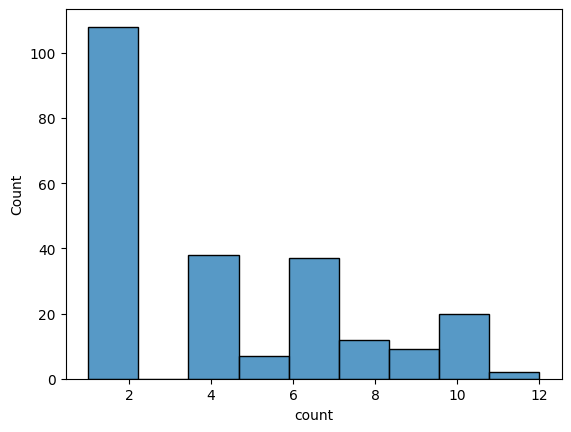

In [10]:
# Visualize distribution of ID count per profile
main_id_counts = main_ids.value_counts()
sns.histplot(main_id_counts)

In [11]:
# Distribution of ID count per profile
profiles_per_id_count = main_ids.value_counts().value_counts()
pd.DataFrame({"ID_COUNT":profiles_per_id_count.index, "PROFILE_COUNT":profiles_per_id_count.values})

,ID_COUNT,PROFILE_COUNT
0,1,108
1,4,38
2,7,28
3,10,20
4,8,12
5,9,9
6,6,9
7,5,7
8,12,2


In [12]:
# Ten profiles with most stitched IDs
main_id_counts.nlargest(10)

USER_MAIN_ID
rid2279fd7f4fefb35cbfca8e2dc0cd4082    12
rid43dbd0c4ca4fd27eb71233a05252a65b    12
rid68b33a0f9d6fb9f5c1acd60988e1b210    10
rid09044529ed1d057ebd43baec593d10da    10
rid1802d7bdbe2e66d7f0828d85cd82eaa1    10
rid912c2c911c8134291e0bc439684ab5c6    10
ridc8332feb663c4c57ac6f607ae2d6dd79    10
rid0e565790532b46db784738e309fcbbd1    10
rid15eedb47bc19c24f0ae7e7f1db565dfa    10
ridb3c2484692328fde9190023eeb430ccb    10
Name: count, dtype: int64

## Profile with Most IDs

In [13]:
# Profile with most IDs
most_frequent_main_id = main_ids.mode()[0]
id_graph[id_graph[rudder_id] == most_frequent_main_id]

,USER_MAIN_ID,OTHER_ID,OTHER_ID_TYPE,VALID_AT,FIRST_SEEN_AT
52,rid2279fd7f4fefb35cbfca8e2dc0cd4082,f7c3885b-3282-4d21-8667-a816760f275f,anonymous_id,2024-03-15 15:27:20.469,2024-03-15 15:27:20.469
132,rid2279fd7f4fefb35cbfca8e2dc0cd4082,b8d058a3-f091-4b60-9664-55041e94350f,anonymous_id,2024-03-15 15:27:20.467,2024-03-15 15:27:20.467
162,rid2279fd7f4fefb35cbfca8e2dc0cd4082,2413ee73-e6e9-4122-be9a-af9e44458cfa,anonymous_id,2024-03-15 15:27:20.470,2024-03-15 15:27:20.470
228,rid2279fd7f4fefb35cbfca8e2dc0cd4082,51242fa5-760d-4186-984c-2ccd3290c9a0,anonymous_id,2024-03-15 15:27:20.466,2024-03-15 15:27:20.466
282,rid2279fd7f4fefb35cbfca8e2dc0cd4082,5b7188e8-cee9-42db-8806-71eef28926b5,user_id,2024-03-15 15:27:20.466,2024-03-15 15:27:20.465
284,rid2279fd7f4fefb35cbfca8e2dc0cd4082,percyo'connell@outstanding-delay.biz,email,2024-03-15 15:27:20.466,2024-03-15 15:27:20.465
422,rid2279fd7f4fefb35cbfca8e2dc0cd4082,038-210-4842,phone,2024-03-15 15:27:20.466,2024-03-15 15:27:20.465
476,rid2279fd7f4fefb35cbfca8e2dc0cd4082,ae278782-e354-45c7-a93a-fe3bbdb04b7b,anonymous_id,2024-03-15 15:27:20.468,2024-03-15 15:27:20.467
521,rid2279fd7f4fefb35cbfca8e2dc0cd4082,06a7eb16-69bc-4f1f-8f5f-f6735ffd842b,anonymous_id,2024-03-15 15:27:20.486,2024-03-15 15:27:20.486
746,rid2279fd7f4fefb35cbfca8e2dc0cd4082,513e9b0f-f434-47d7-94a4-1395563c791f,anonymous_id,2024-03-15 15:27:20.468,2024-03-15 15:27:20.468


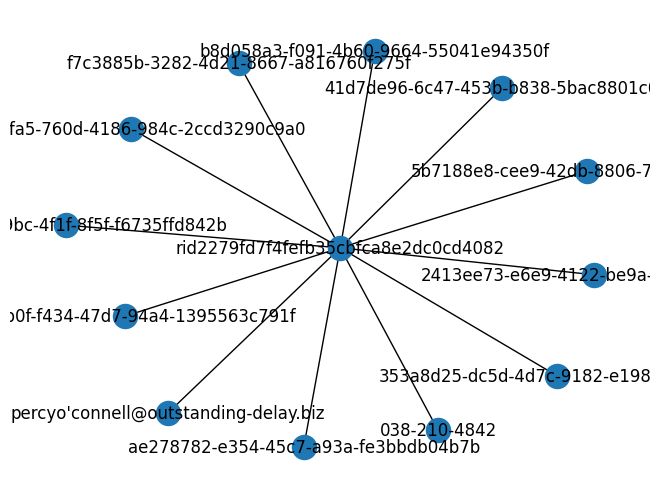

In [14]:
# Visualize ID graph for profile with most IDs
G = nx.Graph()
for index, row in id_graph[id_graph[rudder_id] == most_frequent_main_id].iterrows():
    G.add_nodes_from([
        (row[rudder_id], {"type": "main_id"}),
        (row["OTHER_ID"], {"type": row["OTHER_ID_TYPE"]}),
    ])
    G.add_edge(row[rudder_id], row["OTHER_ID"])

plt.tight_layout()
nx.draw(G, pos=nx.spring_layout(G), with_labels=True)

In [15]:
# Retrieve latest model name and edges table and load them into a pandas DataFrame
sql = f"""
select
    'material_' || model_name || '_' || model_hash || '_' || seq_no  as model_name,
    'material_' || model_name || '_' || model_hash || '_' || seq_no || '_internal_edges' as edges_table
from {creds['dbname']}.{creds['schema']}.MATERIAL_REGISTRY_4
where
    model_type = 'id_stitcher'
    and metadata:complete:status = 2
qualify rank() over (partition by model_name order by end_ts desc) = 1
limit 1;
"""
material_names = cur.execute(sql).fetch_pandas_all()

# Preview data
material_names.head()

,MODEL_NAME,EDGES_TABLE
0,material_user_id_stitcher_d13cdb3f_11,material_user_id_stitcher_d13cdb3f_11_internal...


In [16]:
# Retrieve stitched IDs from edges table and load them into a pandas DataFrame
sql_template = """
WITH cte_idg AS (
    {% for _ in range(2) -%}
    SELECT
        id{{ loop.index }} AS id_val,
        id{{ loop.index }}_type AS id_type,
        id{{ 3 - loop.index }} AS id_other,
        id{{ 3 - loop.index }}_type AS other_id_type,
        {{ rudder_id }}
    FROM {{ edges_table }}
    WHERE
        id1 <> id2
        AND id{{ loop.index }} || id{{ loop.index }}_type IN (
            SELECT OTHER_ID || other_id_type
            FROM {{ model_name }}
            WHERE {{ rudder_id }} = '{{ entity_main_id }}'
        )
    {% if not loop.last -%}
    UNION ALL
    {% endif %}
    {%- endfor %}
)

SELECT
    id_type,
    id_val,
    ARRAY_AGG(OBJECT_CONSTRUCT(other_id_type, id_other)) AS id_list,
    {%- for id_type in id_types %}
    SUM(${{ loop.index + 4 }}) AS {{ id_type }}_count,
    {%- endfor %}
    {% for id_type in id_types -%}
    SUM(${{ loop.index + 4 }})
    {%- if not loop.last %} + {% endif %}
    {%- endfor %} AS total_count
FROM (
    SELECT
        id_val,
        id_type,
        id_other,
        other_id_type,
        {%- for id_type in id_types %}
        CASE WHEN other_id_type = '{{ id_type }}' THEN 1 ELSE 0 END AS {{ id_type }}
        {%- if not loop.last -%}
        , 
        {%- endif -%}
        {%- endfor %}
    FROM cte_idg
)
GROUP BY 1, 2
ORDER BY total_count DESC;
"""
sql = jinja2.Template(sql_template).render(
    id_types=list(id_graph["OTHER_ID_TYPE"].unique()),
    model_name=material_names["MODEL_NAME"][0],
    edges_table=material_names["EDGES_TABLE"][0],
    rudder_id=rudder_id,
    entity_main_id=most_frequent_main_id
)
stitched_ids = cur.execute(sql).fetch_pandas_all()

# Preview first ten rows
stitched_ids.head(10)

,ID_TYPE,ID_VAL,ID_LIST,PHONE_COUNT,EMAIL_COUNT,ANONYMOUS_ID_COUNT,USER_ID_COUNT,TOTAL_COUNT
0,user_id,5b7188e8-cee9-42db-8806-71eef28926b5,"[\n {\n ""anonymous_id"": ""f7c3885b-3282-4d2...",1,1,9,0,11
1,email,percyo'connell@outstanding-delay.biz,"[\n {\n ""phone"": ""038-210-4842""\n },\n {...",1,0,1,1,3
2,anonymous_id,353a8d25-dc5d-4d7c-9182-e198330ab978,"[\n {\n ""phone"": ""038-210-4842""\n },\n {...",1,1,0,1,3
3,phone,038-210-4842,"[\n {\n ""user_id"": ""5b7188e8-cee9-42db-880...",0,1,1,1,3
4,anonymous_id,513e9b0f-f434-47d7-94a4-1395563c791f,"[\n {\n ""user_id"": ""5b7188e8-cee9-42db-880...",0,0,0,1,1
5,anonymous_id,b8d058a3-f091-4b60-9664-55041e94350f,"[\n {\n ""user_id"": ""5b7188e8-cee9-42db-880...",0,0,0,1,1
6,anonymous_id,f7c3885b-3282-4d21-8667-a816760f275f,"[\n {\n ""user_id"": ""5b7188e8-cee9-42db-880...",0,0,0,1,1
7,anonymous_id,ae278782-e354-45c7-a93a-fe3bbdb04b7b,"[\n {\n ""user_id"": ""5b7188e8-cee9-42db-880...",0,0,0,1,1
8,anonymous_id,41d7de96-6c47-453b-b838-5bac8801c08b,"[\n {\n ""user_id"": ""5b7188e8-cee9-42db-880...",0,0,0,1,1
9,anonymous_id,51242fa5-760d-4186-984c-2ccd3290c9a0,"[\n {\n ""user_id"": ""5b7188e8-cee9-42db-880...",0,0,0,1,1


In [17]:
# Build Python dictionary with ID lists
stitched_ids_dict = {}
for index, row in stitched_ids.iterrows():
    stitched_ids_dict[f"{row['ID_TYPE']}:{row['ID_VAL']}"] = json.loads(row["ID_LIST"])

pprint.pprint(stitched_ids_dict)

{'anonymous_id:06a7eb16-69bc-4f1f-8f5f-f6735ffd842b': [{'user_id': '5b7188e8-cee9-42db-8806-71eef28926b5'}],
 'anonymous_id:2413ee73-e6e9-4122-be9a-af9e44458cfa': [{'user_id': '5b7188e8-cee9-42db-8806-71eef28926b5'}],
 'anonymous_id:353a8d25-dc5d-4d7c-9182-e198330ab978': [{'phone': '038-210-4842'},
                                                       {'email': "percyo'connell@outstanding-delay.biz"},
                                                       {'user_id': '5b7188e8-cee9-42db-8806-71eef28926b5'}],
 'anonymous_id:41d7de96-6c47-453b-b838-5bac8801c08b': [{'user_id': '5b7188e8-cee9-42db-8806-71eef28926b5'}],
 'anonymous_id:51242fa5-760d-4186-984c-2ccd3290c9a0': [{'user_id': '5b7188e8-cee9-42db-8806-71eef28926b5'}],
 'anonymous_id:513e9b0f-f434-47d7-94a4-1395563c791f': [{'user_id': '5b7188e8-cee9-42db-8806-71eef28926b5'}],
 'anonymous_id:ae278782-e354-45c7-a93a-fe3bbdb04b7b': [{'user_id': '5b7188e8-cee9-42db-8806-71eef28926b5'}],
 'anonymous_id:b8d058a3-f091-4b60-9664-55041e9435

In [18]:
# Close Snowflake cursor and connection
# Keep at end of notebook
cur.close()
ctx.close()